In [187]:
#(also include sub-net failiure)

In [188]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import random as ra

from sklearn.cluster import AgglomerativeClustering
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize

import networkx as nx
from scipy.ndimage import distance_transform_edt

In [189]:
input_size = 784
hidden_size0 = 32
hidden_size1 = 16
out_size = 10
epochs = 10
batch_size = 64
learning_rate = 0.001

In [190]:
test_dataset = datasets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [191]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size0, hidden_size1, out_size):
        super(Net, self).__init__()
        self.fc0 = nn.Linear(input_size, hidden_size0)     #784 - 32
        self.fc1 = nn.Linear(hidden_size0, hidden_size1)   #32 - 16
        self.fc2 = nn.Linear(hidden_size1, out_size)       #16 - 10
        self.tanh = nn.Tanh()
        self.init_weights()

    def init_weights(self):
        nn.init.xavier_uniform_(self.fc0.weight, gain=nn.init.calculate_gain('tanh')) 
        nn.init.xavier_uniform_(self.fc1.weight, gain=nn.init.calculate_gain('tanh'))
        nn.init.xavier_uniform_(self.fc2.weight, gain=nn.init.calculate_gain('tanh'))

    def forward(self, x):
        out = self.tanh(self.fc0(x))
        out = self.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [192]:
net = Net(input_size, hidden_size0, hidden_size1, out_size)
CUDA = torch.cuda.is_available()
if CUDA:
    net = net.cuda()

In [193]:
net.load_state_dict(torch.load("02_ffn_mnist_full.pth"))

<All keys matched successfully>

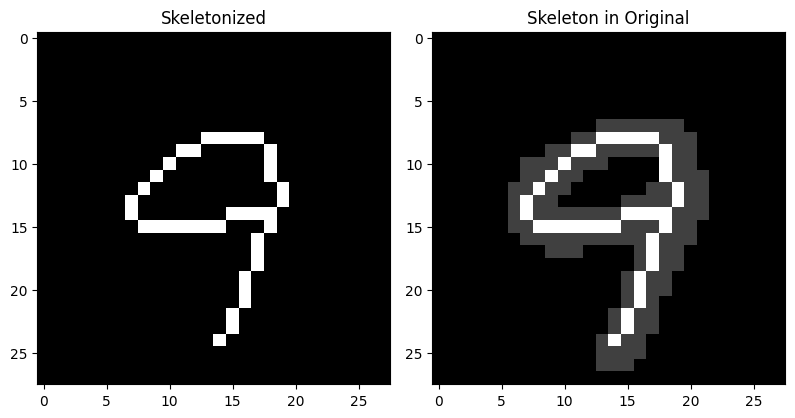

In [194]:
inputs, labels = next(iter(test_loader))

#search wanted digit:
ind = ra.randrange(0, len(inputs))
img = inputs[ind].squeeze()

img_np = img.cpu().numpy()
filtered = img_np > 0.5 #converting to binary, threshold faciliates clean skeleotnization
skeleton = skeletonize(filtered) #skeletonize -> see mathematical definition of algorithm

original_background = torch.where(
    img == 0,
    torch.tensor(0.0, device=img.device),
    0.25
)

y_true, x_true = np.where(skeleton)
for y, x in zip(y_true, x_true):
    original_background[y, x] = 1 #project skeleton onto original_background for clear visualization

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Skeletonized")
plt.imshow(skeleton, cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Skeleton in Original")
plt.imshow(original_background, cmap="gray")

plt.tight_layout()
plt.show()

In [195]:
#converting graph to skeleton pixels
def build_pixel_graph(skeleton):
    G = nx.Graph()
    rows, cols = skeleton.shape
    for i in range(rows):
        for j in range(cols):
            if skeleton[i, j]:
                G.add_node((i, j))
                for dx in [-1, 0, 1]: #8 neighbors
                    for dy in [-1, 0, 1]:
                        if dx == 0 and dy == 0:
                            continue
                        ni, nj = i + dx, j + dy
                        if 0 <= ni < rows and 0 <= nj < cols and skeleton[ni, nj]:
                            G.add_edge((i, j), (ni, nj))
    return G

#finding localized clusters in graph G
def find_clusters(G, min_size=5, max_size=10):
    clusters = []
    seen = set()

    def dfs(node, cluster, visited):
        if len(cluster) > max_size:
            return
        cluster_key = tuple(sorted(cluster))
        if cluster_key not in seen and min_size <= len(cluster) <= max_size:
            seen.add(cluster_key)
            clusters.append(cluster.copy())

        for neighbor in G[node]:
            if neighbor not in visited:
                dfs(neighbor, cluster + [neighbor], visited | {neighbor})

    for node in G.nodes:
        dfs(node, [node], set([node]))

    return clusters

#converting to tensor
def clusters_to_tensor(clusters, shape=(28, 28)):
    masks = []
    for cluster in clusters:
        mask = np.zeros(shape, dtype=np.uint8)
        for (i, j) in cluster:
            mask[i, j] = 1
        masks.append(mask)
    return torch.tensor(np.stack(masks), dtype=torch.uint8).permute(1, 2, 0)

Found 68 concept clusters


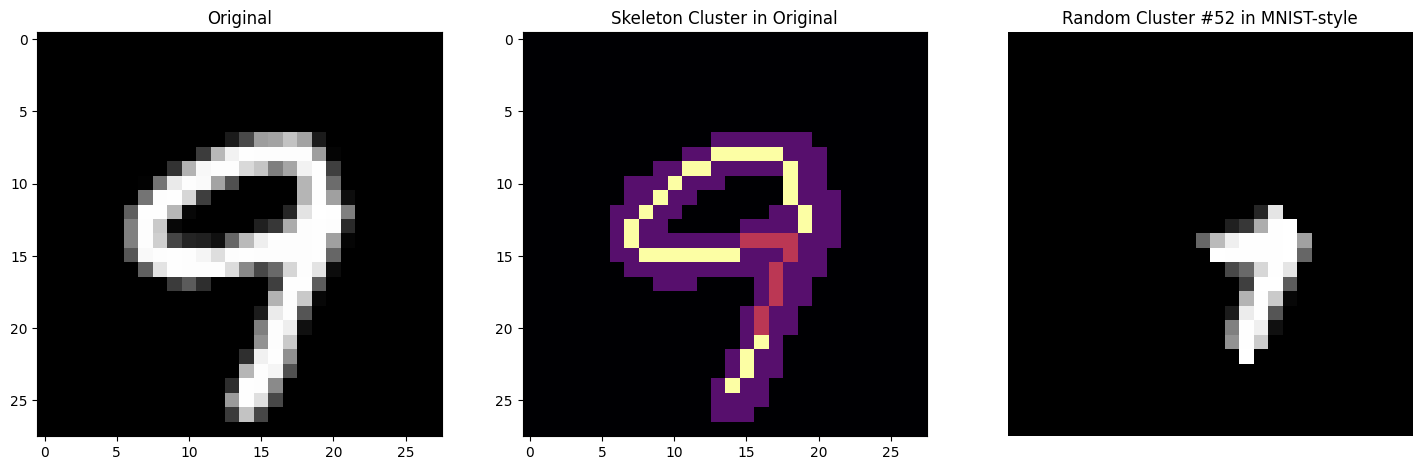

In [196]:
#execution
G = build_pixel_graph(skeleton)
clusters = find_clusters(G, min_size=10, max_size=10)
clusters_tensor = clusters_to_tensor(clusters) #[28, 28, n]
print(f"Found {clusters_tensor.shape[2]} concept clusters")

#randomly selecting example cluster for visualization:
random_idx = ra.randint(0, clusters_tensor.shape[2] - 1)

#visualising the cluster in the original digit:
y_true, x_true = np.where(skeleton)
for y, x in zip(y_true, x_true):
    original_background[y, x] = 1 #project skeleton onto original for clear visualization

random_cluster_mask = clusters_tensor[:, :, random_idx].numpy()
for y, x in np.argwhere(random_cluster_mask == 1):
    original_background[y, x] = 0.5 #highlighting selected cluster in skeleton

#converting cluster to original MNIST-style (to later input to the net, has to be same style due to overfitting on style)
inverted_mask = 1 - random_cluster_mask
distance = distance_transform_edt(inverted_mask)
within_range_mask = (distance <= 2).astype(np.float32)
original_style_cluster = torch.from_numpy(img_np * within_range_mask) #back to tensor cause I'll give it to the model

#plotting
plt.figure(figsize=(24, 8))

plt.subplot(1, 4, 1)
plt.title('Original')
plt.imshow(img, cmap='gray')

plt.subplot(1, 4, 2)
plt.title("Skeleton Cluster in Original")
plt.imshow(original_background, cmap='inferno')

plt.subplot(1, 4, 3)
plt.title(f'Random Cluster #{random_idx} in MNIST-style')
plt.imshow(original_style_cluster, cmap='gray')

plt.axis('off')
plt.show()

original_clusters = torch.zeros_like(clusters_tensor)
original_clusters = []

#generating list of clusters in original MNIST-style
for i in range(clusters_tensor.shape[2]):
    mask = clusters_tensor[:, :, i].numpy()
    inverted_mask = 1 - mask
    distance = distance_transform_edt(inverted_mask)
    within_range_mask = (distance <= 2).astype(np.float32)
    new_input = torch.from_numpy(img_np * within_range_mask).float()
    original_clusters.append(new_input)


In [197]:

with torch.no_grad():
    activations_this_class = []
    for input_mat in original_clusters:
        if CUDA:
            input_mat = input_mat.cuda()

        a0 = F.tanh(net.fc0(input_mat.float().view(-1)))
        a1 = F.tanh(net.fc1(a0))
        logits = net.fc2(a1)

        prob_distr = torch.sigmoid(logits)

        confidence = (torch.max(prob_distr) - (1/9) * (torch.sum(prob_distr) - torch.max(prob_distr))) #how much the predicted class was activated relative to the average activaion of all other classes

        activations_this_class.append(confidence)

    scalars = [x.item() for x in activations_this_class]
    min_val = min(scalars)
    max_val = max(scalars)
    
    zero_point = min_val + (max_val-min_val)/2
    max_factor = 1/(max_val-zero_point)
    


In [198]:
def normalise_importance(val):
    return max_factor * (val - zero_point)

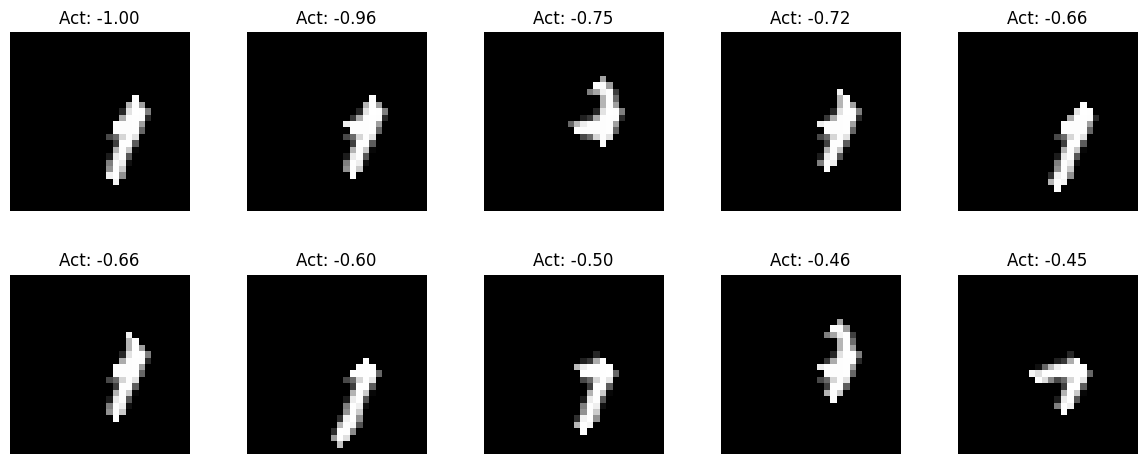

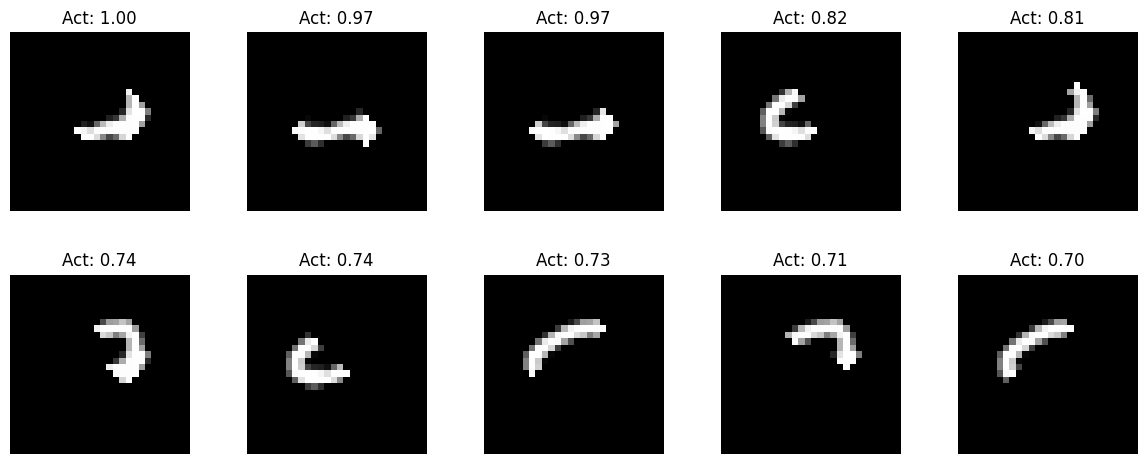

In [199]:
activations = torch.tensor([a.item() for a in activations_this_class])

lowest_10_values, last_10_indices = torch.topk(activations, 10, largest=False)
lowest_10_tensors = [original_clusters[idx] for idx in last_10_indices]

top_10_values, top10_indices = torch.topk(activations, 10, largest=True)
top_10_tensors = [original_clusters[idx] for idx in top10_indices]


fig0, axs0 = plt.subplots(2, 5, figsize=(12, 5))
fig0.tight_layout()
axs0 = axs0.flatten()

for i, ax in enumerate(axs0):
    im = lowest_10_tensors[i]
    ax.imshow(im.numpy(), cmap='gray')
    ax.set_title(f"Act: {normalise_importance(lowest_10_values[i]):.2f}")
    ax.axis('off')

fig1, axs1 = plt.subplots(2, 5, figsize=(12, 5))
fig1.tight_layout()
axs1 = axs1.flatten()

for i, ax in enumerate(axs1):
    im = top_10_tensors[i]
    ax.imshow(im.numpy(), cmap='gray')
    ax.set_title(f"Act: {normalise_importance(top_10_values[i]):.2f}")
    ax.axis('off')

plt.show()

In [200]:
def find_unique_concepts(original_clusters, activations, overlap_threshold):
    activations = torch.tensor(activations)
    abs_activations = activations.abs()
    sorted_indices = torch.argsort(abs_activations, descending=True)
    selected_indices = []

    for i, idx in enumerate(sorted_indices):
        concept_mask = original_clusters[idx] != 0 #mask for selected cluster

        if i == 0:
            selected_indices.append(idx.item()) #which cluster to display in visualisation

        similarities = []
        for ind in selected_indices:
            comp_mask = original_clusters[ind] != 0 #comparing to other masks to prevent high overlap
            normaliser = concept_mask.sum().float() if concept_mask.sum().float() < comp_mask.sum().float() else comp_mask.sum().float() #determine bigger mask
            similarities.append((concept_mask & comp_mask).sum().float() / normaliser)
            #if normaliser was smaller cluster, similarity could become 100% despite low (e.g. 50%) absolute overlap

        max_similarity = max(similarities)

        if max_similarity < overlap_threshold:
            comp_mask = concept_mask
            selected_indices.append(idx.item())

    return selected_indices


Selected concept indices: [32, 59, 26, 7, 9, 23, 66, 58, 30]


(-0.5, 27.5, 27.5, -0.5)

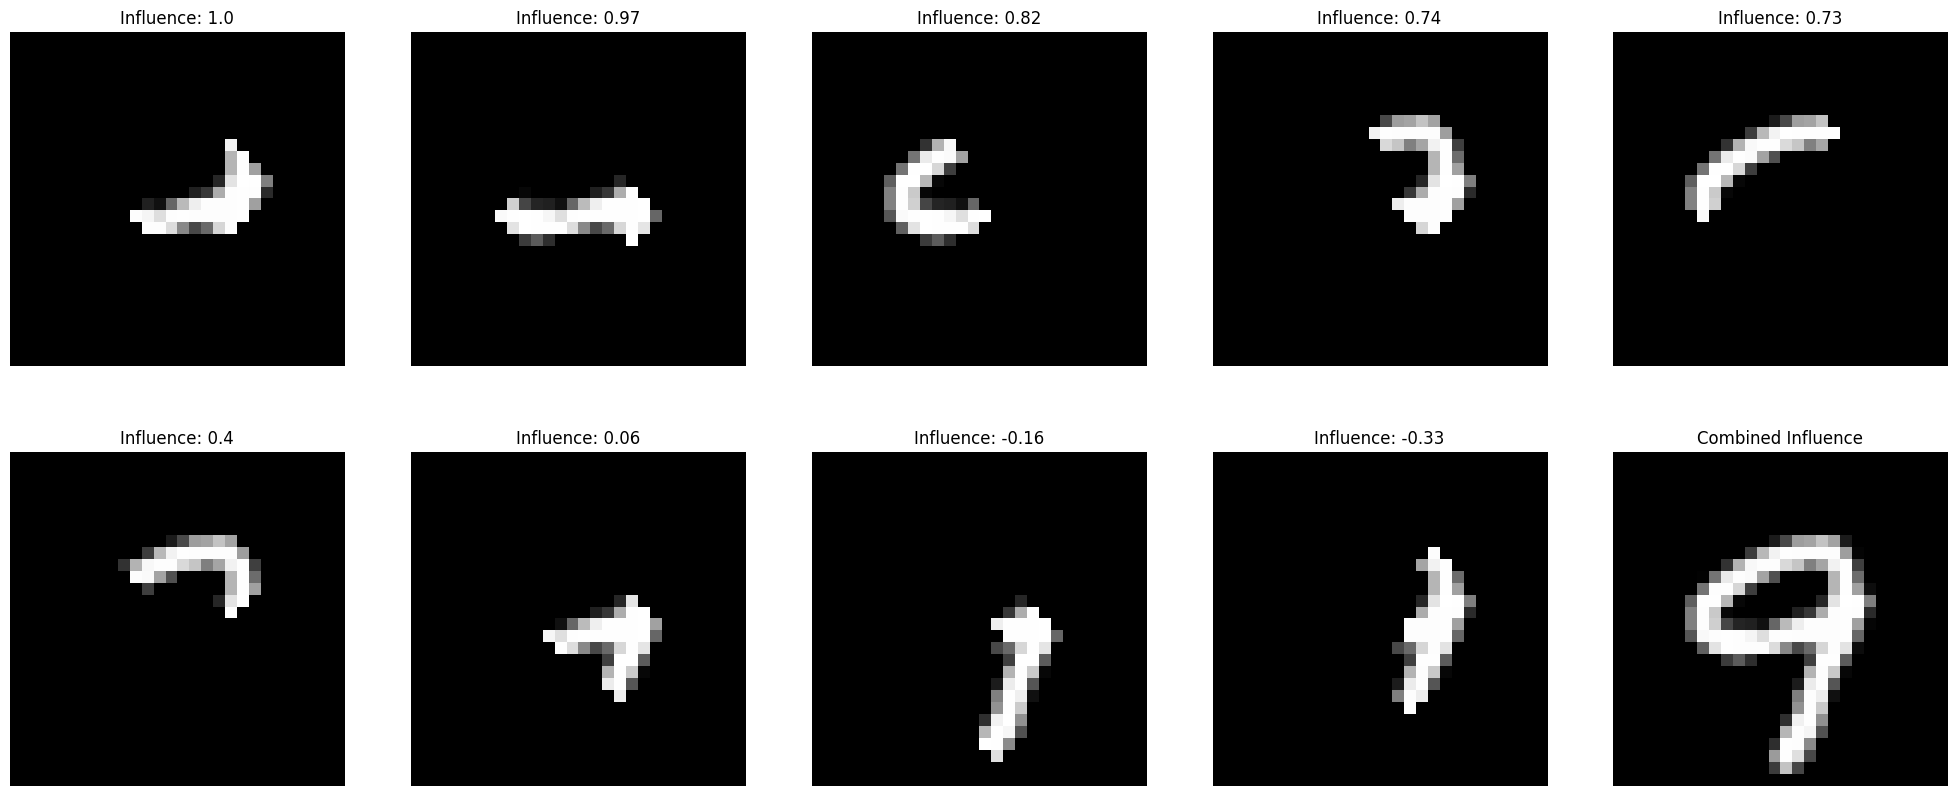

In [201]:
selected_indices = find_unique_concepts(original_clusters, activations_this_class, 0.75)
print("Selected concept indices:", selected_indices)
combined = np.full_like(original_clusters[0], fill_value=-1.0, dtype=float)

rows = -(-(len(selected_indices) + 1) // 5)
plt.figure(figsize=(5 * 5, rows * 5))

for i, idx in enumerate(selected_indices):
    cluster = original_clusters[idx]
    act = activations_this_class[idx].item()

    plt.subplot(rows, 5, i + 1)
    plt.imshow(cluster, cmap='gray')
    plt.title(f"Influence: {round(normalise_importance(act), 2)}")
    plt.axis('off')

plt.subplot(rows, 5, len(selected_indices) + 1)
plt.imshow(img_np, cmap='gray', vmin=0, vmax=1)
plt.title("Combined Influence")
plt.axis('off')

#I had initially planned to combine the clusters into an overlapping visualisation,
#however, strongly opposite values overlapping and averaging created information loss
#The below visualisations are much more interpretable, as they show each cluster seperately,
#to be interpreted as concepts most important to the model
